In [81]:

import sys
import os
import io
import time
import string
import numpy as np
import pandas as pd
import pickle
import re
from collections import defaultdict
import random
import random
import csv
import sqlite3 as lite
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from collections import defaultdict
from IPython.display import clear_output


In [58]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
train_set = "../res/train_set.tsv"
test_set = "../res/test_set.tsv"
valid_set = "../res/valid_set.tsv"
ft_vec = "../res/crawl-300d-2M-subword.vec"
glove50_path = "../res/GloveDict50.pkl"

max_q_len = 10
max_a_len = 100
embedding_len = 50
pad_char = '_'

header_names = ["question","answer","label"]

translator = str.maketrans('', '', string.punctuation)

CUDA is available!  Training on GPU ...


In [31]:
# def load_vectors(fname):
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = map(float, tokens[1:])
#     return data

In [7]:
def load_glove_vectors(fname):
    pickle_in = open(fname,"rb")
    _dict = pickle.load(pickle_in)
    return _dict

In [7]:
# read a val
# embeddings. 

# class CustomDatasetFromCSV(Dataset):
#     def __init__(self, csv_path, transform=None):
#         _dataset = pd.read_csv(csv_path, sep='\t', header=None, names=header_names, encoding='utf8')
#         self.labels = _dataset['label']
#         self.questions = _dataset['question']
#         self.answers = _dataset['answer']

#     def __getitem__(self, index):
#         q = self.questions.iloc[index]
#         a = self.answers.iloc[index]
#         q = q.lower()
#         a = a.lower()
#         x = [q,a]
#         y = self.labels.iloc[index]
#         return x, y
    
#     def __len__(self):
#         return len(self.labels)

In [ ]:
#ft_dict = load_vectors(ft_vec)

In [11]:
glove50 = load_glove_vectors(glove50_path)
supported_words = list(glove50.keys())
print(supported_words[:100])

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after', 'new', 'been', 'also', 'we', 'would', 'two', 'more', "'", 'first', 'about', 'up', 'when', 'year', 'there', 'all', '--', 'out', 'she', 'other', 'people', "n't", 'her', 'percent', 'than', 'over', 'into', 'last', 'some', 'government', 'time', '$', 'you', 'years', 'if', 'no', 'world', 'can', 'three', 'do', ';', 'president', 'only', 'state', 'million', 'could', 'us', 'most', '_', 'against', 'u.s.']


In [17]:
default_val = np.zeros(embedding_len)
glove = defaultdict(lambda: default_val,glove50)

In [77]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transform=None):
        _dataset = pd.read_csv(csv_path, sep='\t', header=None, names=header_names, encoding='utf8')
        self.labels = _dataset['label']
        self.questions = _dataset['question']
        self.answers = _dataset['answer']

    def __getitem__(self, index):
        q = self.questions.iloc[index]
        a = self.answers.iloc[index]
        q = q.lower()
        a = a.lower()
        q = q.translate(translator)
        a = a.translate(translator)
        
        tokens = set((q+" "+a).split(" "))
        unique_vals = [x for x in tokens if x not in supported_words]      
        
        
        q_list = np.zeros((max_q_len, (embedding_len+1)))
        a_list = np.zeros((max_a_len, (embedding_len+1)))
        
        
        q_words = q.split(" ")        
        if len(q_words) > max_q_len:
            q_words = q_words[:max_q_len]
        else:
            q_words = [pad_char]*(max_q_len - len(q_words) ) + q_words
            
        a_words = a.split(" ")
        if len(a_words) > max_a_len:
            a_words = a_words[:max_a_len]
        else:
            a_words = [pad_char]*(max_a_len - len(a_words) ) + a_words
        
        
        
        for i, word in enumerate(q_words):
            q_val = glove[word]
            if word not in unique_vals:
                q_val = np.append(q_val, 0)
            else:
                q_val = np.append(q_val, unique_vals.index(word))            
            q_list[i] = q_val
        
            
        for i, word in enumerate(a_words):
            a_val = glove[word]
            if word not in unique_vals:
                a_val = np.append(a_val, 0)
            else:
                a_val = np.append(a_val, unique_vals.index(word))            
            a_list[i] = a_val
        
        
        x = [q_list,a_list]
        y = self.labels.iloc[index]
        return x, y
    def __len__(self):
        return len(self.labels)

In [78]:

# qwc = defaultdict(lambda:0)
# awc = defaultdict(lambda:0)

In [82]:
# apply embeddings in get data itself
# test data loader

start_time = time.clock()

custom_data = CustomDatasetFromCSV(test_set)
    # Define data loader
dataset_loader = torch.utils.data.DataLoader(dataset=custom_data,
                                                    batch_size=32,
                                                    shuffle=False)
count = 0    
for x, y in dataset_loader:    
    q = x[0]
    a = x[1]    
    l = len(y)
    count+=l
    clear_output(wait=True)
    print("done ", count)



    
print("--- %s seconds ---" % (time.clock() - start_time))
# lstm network

done  4194
--- 137.71859526200024 seconds ---


D:\WindowsSoftware\Anaconda\envs\acme\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [44]:
#print(qwc,"\n\n",awc)


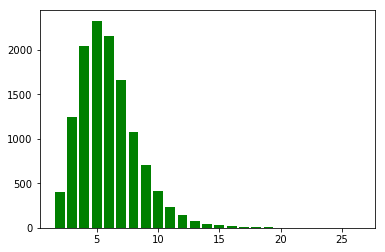

In [27]:
#plt.bar(list(qwc.keys()), qwc.values(), color='g')
#plt.show()

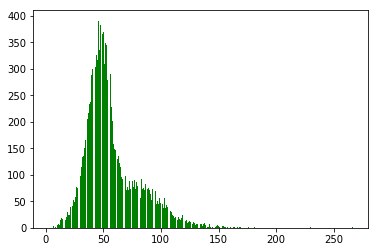

In [28]:
#plt.bar(list(awc.keys()), awc.values(), color='g')
#plt.show()